In [ ]:
!kaggle competitions download -c playground-series-s5e1
!unzip *.zip

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import holidays


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

working_dir = Path().cwd()

In [28]:
train_df = pd.read_csv(working_dir/'train.csv', index_col='id', parse_dates=['date'], infer_datetime_format=True)
train_df

/tmp/ipykernel_30770/2848790620.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  train_df = pd.read_csv(working_dir/'train.csv', index_col='id', parse_dates=['date'], infer_datetime_format=True)


,date,country,store,product,num_sold
id,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
...,...,...,...,...,...
230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0


In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230130 entries, 0 to 230129
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      230130 non-null  datetime64[ns]
 1   country   230130 non-null  object        
 2   store     230130 non-null  object        
 3   product   230130 non-null  object        
 4   num_sold  221259 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 10.5+ MB


,date,num_sold
count,230130,221259.000000
mean,2013-07-02 00:00:00,752.527382
min,2010-01-01 00:00:00,5.000000
25%,2011-10-02 00:00:00,219.000000
50%,2013-07-02 00:00:00,605.000000
75%,2015-04-02 00:00:00,1114.000000
max,2016-12-31 00:00:00,5939.000000
std,NaN,690.165445


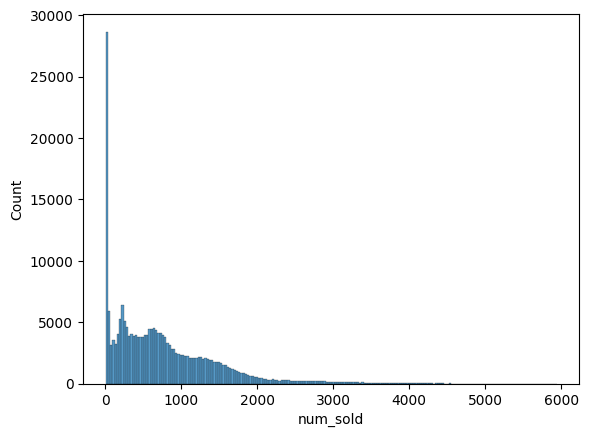

In [30]:
sns.histplot(data=train_df, x='num_sold')

train_df.describe()

In [31]:
def get_unique_vals(df:pd.DataFrame, column:str) -> None:
    print(f'{column} has the following unique entries {len(df[column].unique())}')
    print(f'{df[column].value_counts()}')
    print('-----------------------------------')

get_unique_vals(train_df, 'date')
get_unique_vals(train_df, 'country')
get_unique_vals(train_df, 'store')
get_unique_vals(train_df, 'product')
get_unique_vals(train_df, 'num_sold')

date has the following unique entries 2557
date
2016-12-31    90
2010-01-01    90
2010-01-02    90
2010-01-03    90
2010-01-04    90
              ..
2010-01-18    90
2010-01-17    90
2010-01-16    90
2010-01-15    90
2010-01-14    90
Name: count, Length: 2557, dtype: int64
-----------------------------------
country has the following unique entries 6
country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64
-----------------------------------
store has the following unique entries 3
store
Discount Stickers       76710
Stickers for Less       76710
Premium Sticker Mart    76710
Name: count, dtype: int64
-----------------------------------
product has the following unique entries 5
product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64
-----------------------------------
num_sold h

In [32]:
train_df['num_sold'].isnull().sum()

np.int64(8871)

In [33]:
train_df[train_df['num_sold'].isna()]

,date,country,store,product,num_sold
id,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
45,2010-01-01,Kenya,Discount Stickers,Holographic Goose,NaN
90,2010-01-02,Canada,Discount Stickers,Holographic Goose,NaN
135,2010-01-02,Kenya,Discount Stickers,Holographic Goose,NaN
180,2010-01-03,Canada,Discount Stickers,Holographic Goose,NaN
...,...,...,...,...,...
229905,2016-12-29,Kenya,Discount Stickers,Holographic Goose,NaN
229950,2016-12-30,Canada,Discount Stickers,Holographic Goose,NaN
229995,2016-12-30,Kenya,Discount Stickers,Holographic Goose,NaN


In [34]:
pd.crosstab(
    index=train_df['country'], columns=[train_df['store'], train_df['product']]
)


store     Discount Stickers                                                  \
product   Holographic Goose Kaggle Kaggle Tiers Kerneler Kerneler Dark Mode   
country                                                                       
Canada                 2557   2557         2557     2557               2557   
Finland                2557   2557         2557     2557               2557   
Italy                  2557   2557         2557     2557               2557   
Kenya                  2557   2557         2557     2557               2557   
Norway                 2557   2557         2557     2557               2557   
Singapore              2557   2557         2557     2557               2557   

store     Premium Sticker Mart                               \
product      Holographic Goose Kaggle Kaggle Tiers Kerneler   
country                                                       
Canada                    2557   2557         2557     2557   
Finland                   2557   2557         2557     2557   
Italy                     2557   2557         2557     2557   
Kenya                     2557   2557         2557     2557   
Norway                    2557   2557         2557     2557   
Singapore                 2557   2557         2557     2557   

store                        Stickers for Less                               \
product   Kerneler Dark Mode Holographic Goose Kaggle Kaggle Tiers Kerneler   
country                                                                       
Canada                  2557              2557   2557         2557     2557   
Finland                 2557              2557   2557         2557     2557   
Italy                   2557              2557   2557         2557     2557   
Kenya                   2557              2557   2557         2557     2557   
Norway                  2557              2557   2557         2557     2557   
Singapore               2557              2557   2557         2557     2557   

store                         
product   Kerneler Dark Mode  
country                       
Canada                  2557  
Finland                 2557  
Italy                   2557  
Kenya                   2557  
Norway                  2557  
Singapore               2557

<Axes: >

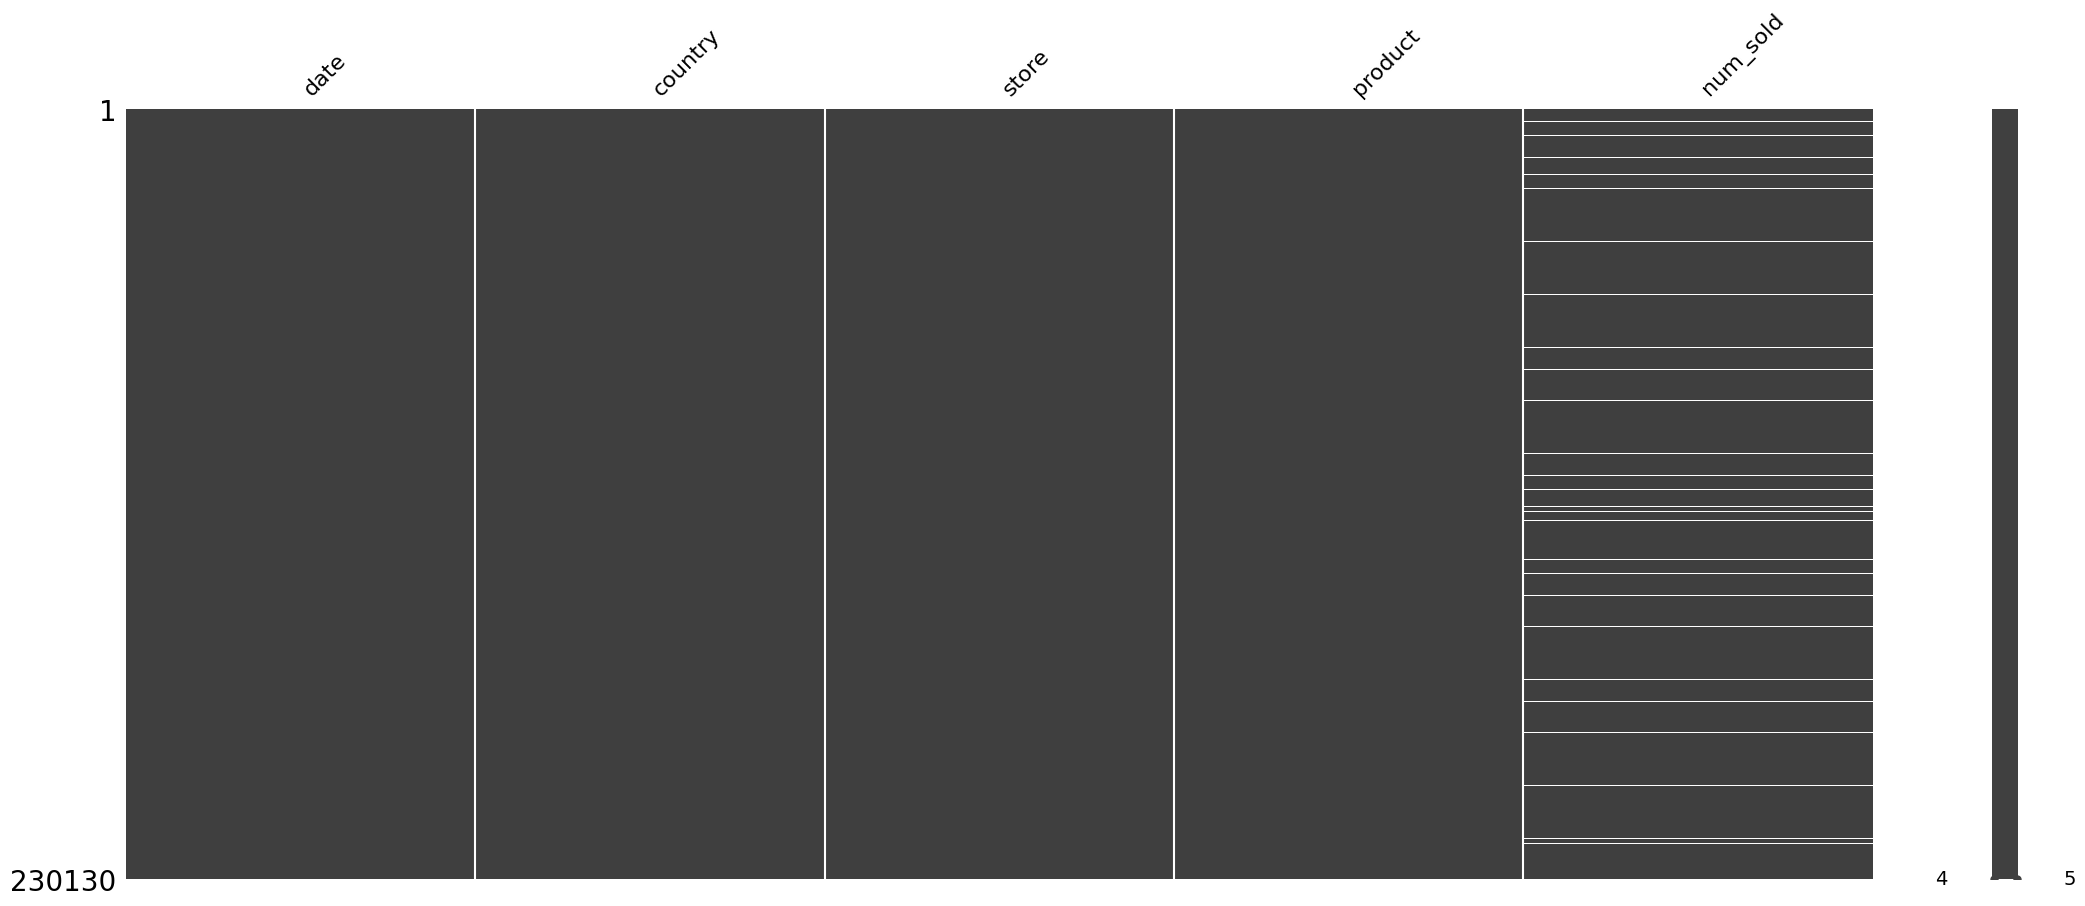

In [35]:
import missingno as msno

msno.matrix(train_df)

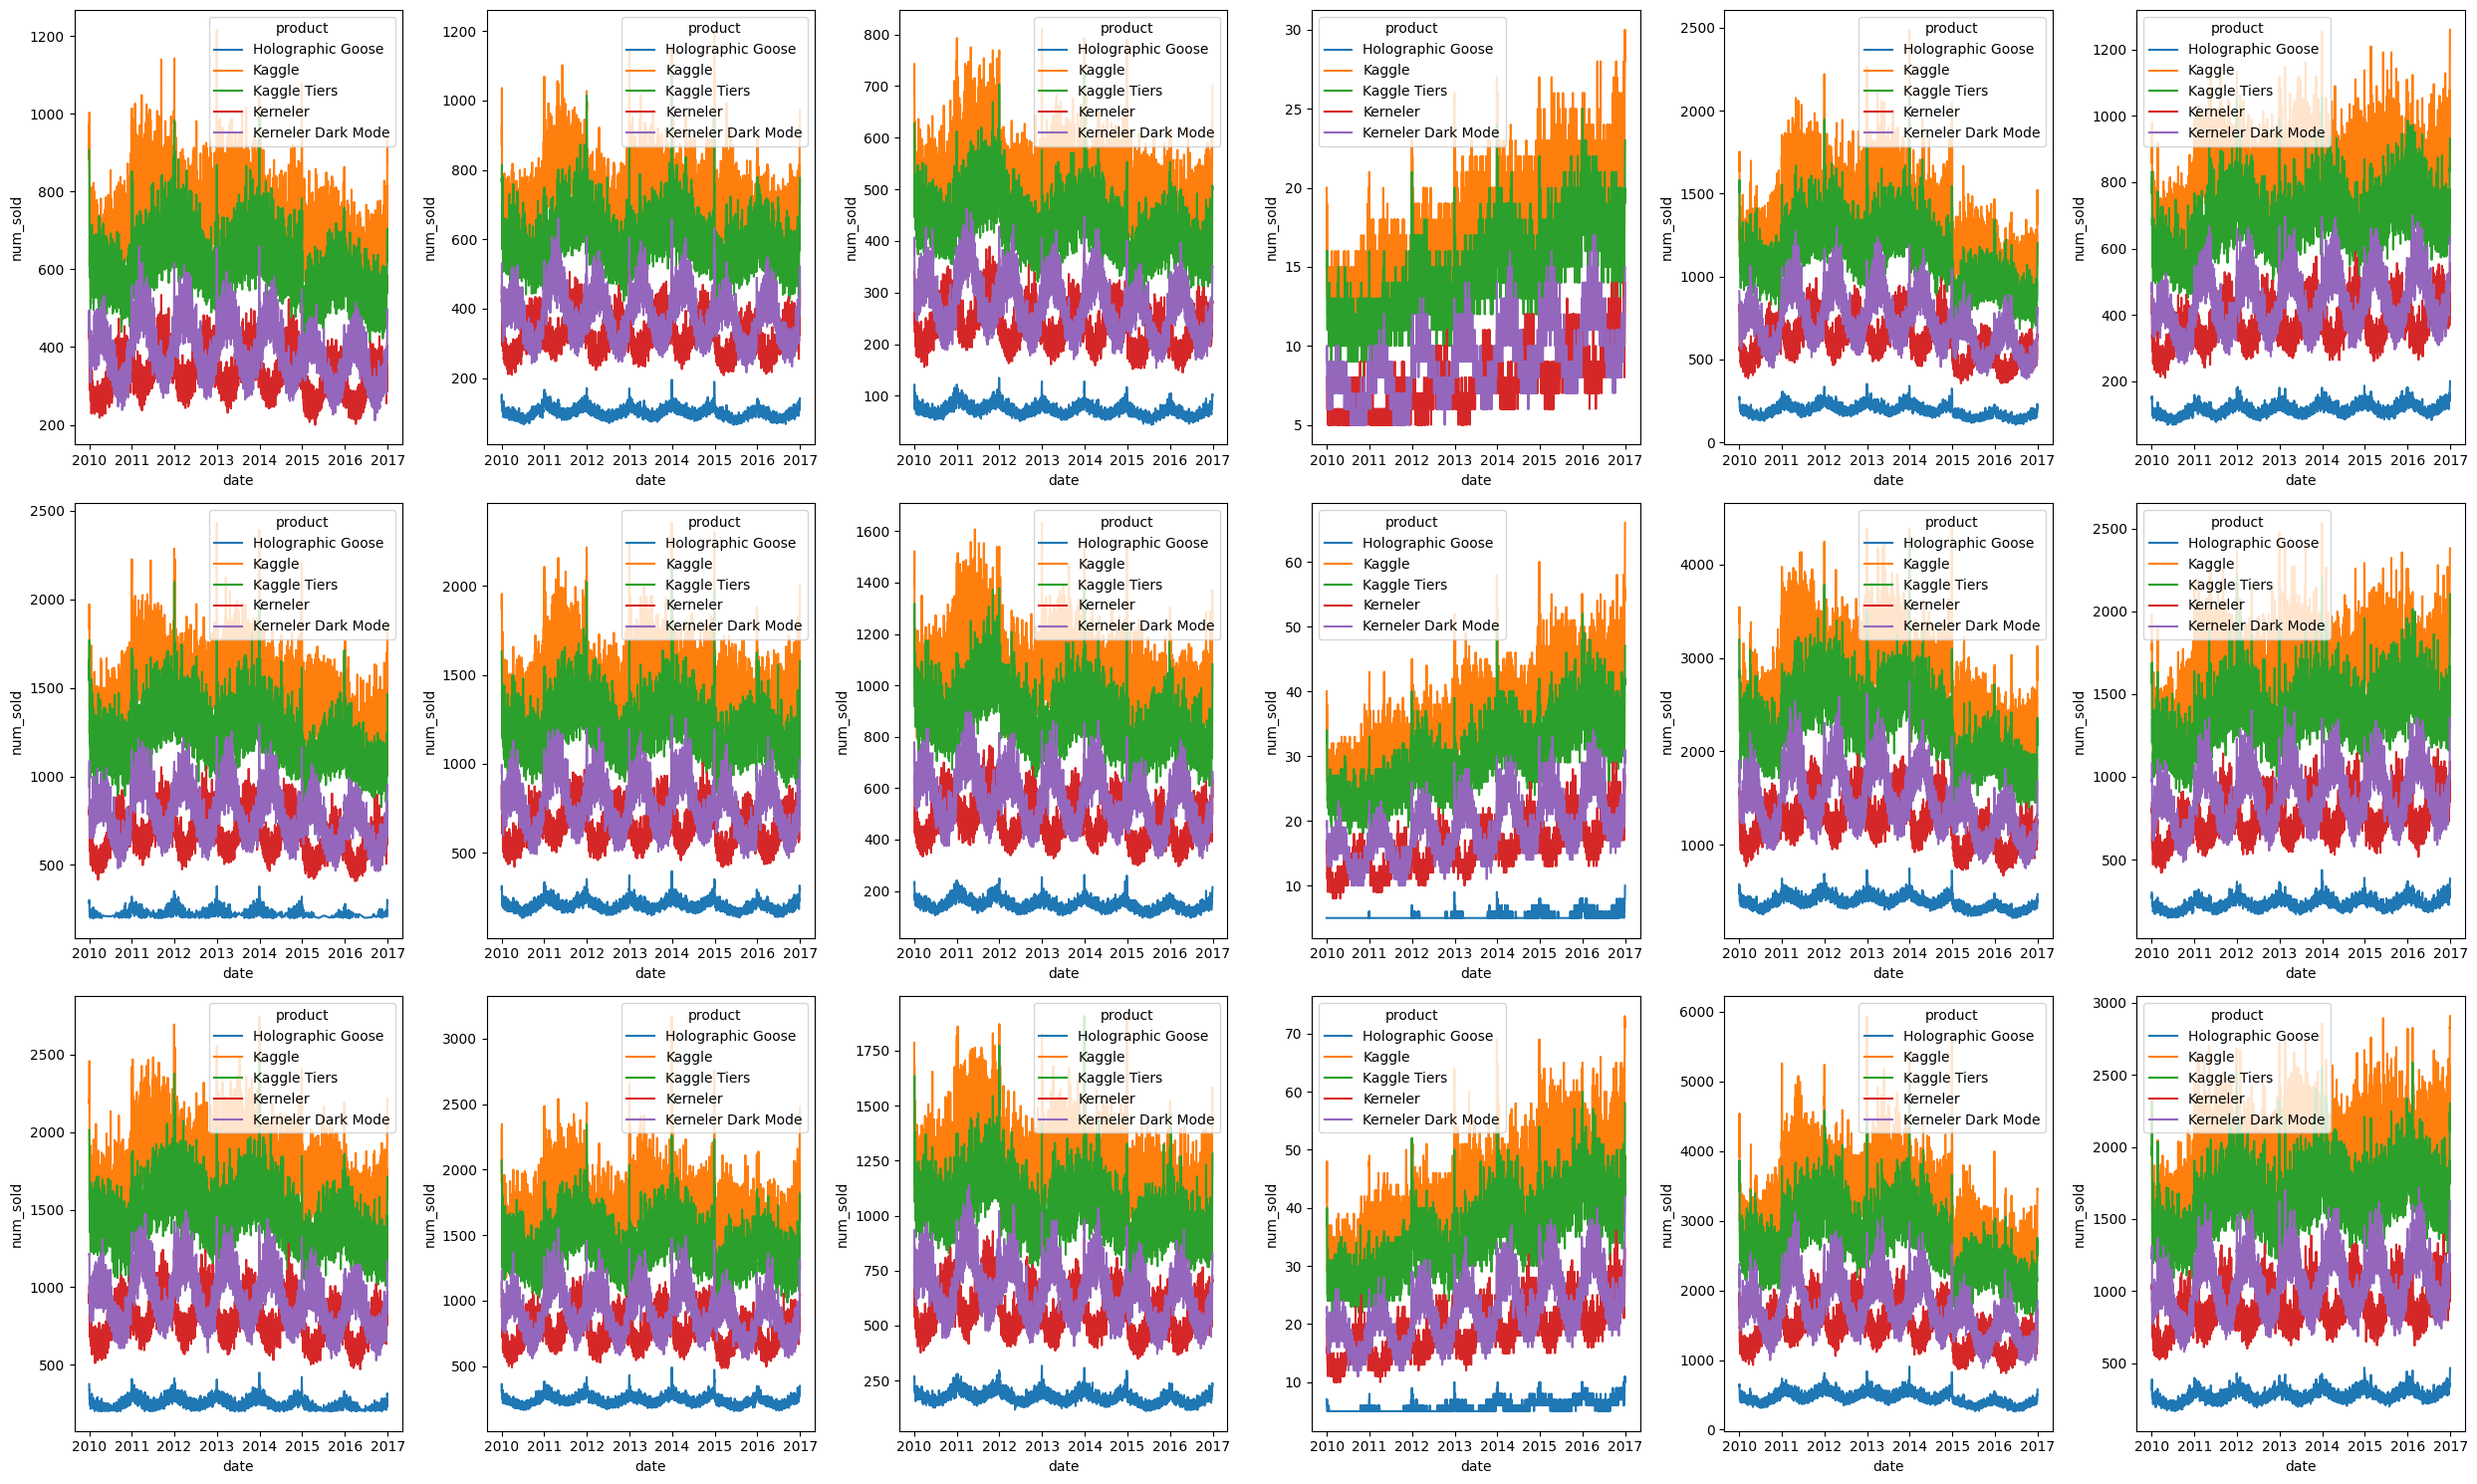

In [36]:
fig, ax = plt.subplots(
    ncols=len(train_df.country.unique()), 
    nrows=len(train_df.store.unique()),
    figsize=(25,15))

for i, country in enumerate(train_df.country.unique()):
    for j, store in enumerate(train_df.store.unique()):
        sns.lineplot(
            data=train_df.query('country == @country and store == @store'),
            x='date',
            y='num_sold',
            hue='product',
            ax=ax[j][i]
        )

fig.tight_layout()
plt.show()

In [37]:

# from https://www.kaggle.com/code/ryanholbrook/seasonality

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(timeseries, time_column, value_column, sampling=pd.Timedelta('1D'), detrend='linear', ax=None):
    from scipy.signal import periodogram
    freqencies, spectrum = periodogram(
        timeseries[value_column],
        fs=pd.to_timedelta(timeseries[time_column].max()-timeseries[time_column].min(), unit='D')/sampling,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax



In [66]:
train_df['day']= train_df['date'].dt.day
train_df['week']= train_df['date'].dt.isocalendar().week
train_df['weekday']= train_df['date'].dt.weekday
train_df['month']= train_df['date'].dt.month
train_df['year']= train_df['date'].dt.year

train_df['day_sin'] = np.sin(2 * np.pi * train_df['day'] / 365)
train_df['day_cos'] = np.cos(2 * np.pi * train_df['day'] / 365)
train_df['month_sin'] = np.sin(2 * np.pi * train_df['month'] / 12)
train_df['month_cos'] = np.cos(2 * np.pi * train_df['month'] / 12)
train_df['year_sin'] = np.sin(2 * np.pi * train_df['year'] / 7)
train_df['year_cos'] = np.cos(2 * np.pi * train_df['year'] / 7)

def is_holiday(row):
    return row['date'] in holidays.country_holidays(row['country'], years=row['year'])

train_df['holiday'] = train_df.apply(is_holiday, axis=1)

train_df


,date,country,store,product,num_sold,day,week,weekday,month,year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,holiday
id,,,,,,,,,,,,,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,1,53,4,1,2010,0.017213,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,True
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,1,53,4,1,2010,0.017213,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,True
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,1,53,4,1,2010,0.017213,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,True
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,1,53,4,1,2010,0.017213,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,True
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,1,53,4,1,2010,0.017213,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,31,52,5,12,2016,0.508671,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000,False
230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,31,52,5,12,2016,0.508671,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000,False
230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,31,52,5,12,2016,0.508671,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000,False


<Axes: title={'center': 'Seasonal Plot (year/weekday)'}, xlabel='weekday', ylabel='num_sold'>

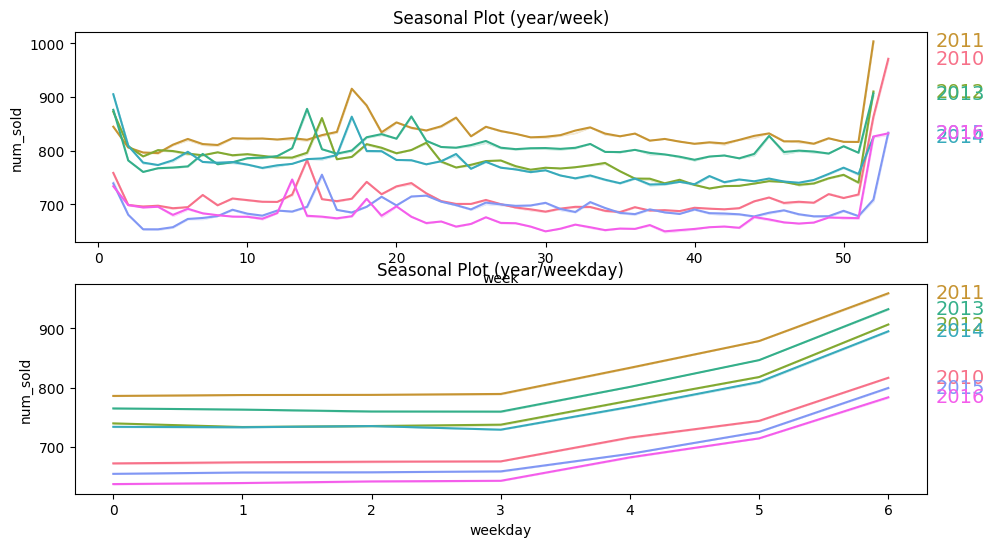

In [39]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(train_df, y="num_sold", period="year", freq="week", ax=ax0)
seasonal_plot(train_df, y="num_sold", period="year", freq="weekday", ax=ax1)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

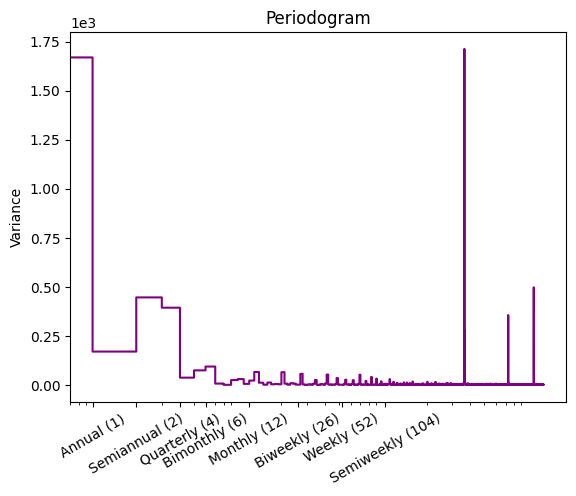

In [54]:
plot_periodogram(
    train_df.fillna(0).query("country == 'Canada' and store == 'Discount Stickers' and product == 'Kaggle'"),
    time_column='date',
    value_column='num_sold',
    sampling=pd.Timedelta('1D'),
    )

In [67]:
train_df

,date,country,store,product,num_sold,day,week,weekday,month,year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,holiday
id,,,,,,,,,,,,,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,1,53,4,1,2010,0.017213,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,True
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,1,53,4,1,2010,0.017213,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,True
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,1,53,4,1,2010,0.017213,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,True
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,1,53,4,1,2010,0.017213,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,True
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,1,53,4,1,2010,0.017213,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,31,52,5,12,2016,0.508671,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000,False
230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,31,52,5,12,2016,0.508671,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000,False
230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,31,52,5,12,2016,0.508671,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000,False


In [68]:
target_col = 'num_sold'
train = train_df.drop(columns=[target_col, 'date'])
target = train_df[target_col]

train

,country,store,product,day,week,weekday,month,year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,holiday
id,,,,,,,,,,,,,,,
0,Canada,Discount Stickers,Holographic Goose,1,53,4,1,2010,0.017213,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,True
1,Canada,Discount Stickers,Kaggle,1,53,4,1,2010,0.017213,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,True
2,Canada,Discount Stickers,Kaggle Tiers,1,53,4,1,2010,0.017213,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,True
3,Canada,Discount Stickers,Kerneler,1,53,4,1,2010,0.017213,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,True
4,Canada,Discount Stickers,Kerneler Dark Mode,1,53,4,1,2010,0.017213,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,Singapore,Premium Sticker Mart,Holographic Goose,31,52,5,12,2016,0.508671,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000,False
230126,Singapore,Premium Sticker Mart,Kaggle,31,52,5,12,2016,0.508671,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000,False
230127,Singapore,Premium Sticker Mart,Kaggle Tiers,31,52,5,12,2016,0.508671,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000,False


In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(
    train,
    target,
    test_size=0.2,
    random_state=42,
)

Y_train = Y_train.fillna(Y_train.mean())
Y_test = Y_test.fillna(Y_test.mean())


In [70]:
from sklearn import tree
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor


transformer = ColumnTransformer(
    transformers=[
        ('categories', OneHotEncoder(sparse_output=False), ['country', 'store', 'product']),
    ], remainder='passthrough'
)

pipe = Pipeline(
    steps=[
        ('transform_columns', transformer),
        ('regression', RandomForestRegressor())
        ]
        )


In [71]:
pipe.fit(
    X_train,
    Y_train
)

/home/mihofer/Repos/kaggle_projects/statspython/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('transform_columns',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categories',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['country', 'store',
                                                   'product'])])),
                ('regression', RandomForestRegressor())])

In [72]:
print(mean_absolute_error(Y_test, pipe.predict(X_test)))
print(mean_absolute_percentage_error(Y_test, pipe.predict(X_test)))


39.95972793026836
0.2510414461302347


In [73]:

cv_results_tree_regressor = cross_validate(
    pipe,
    train,
    target.fillna(target.mean()),
    cv=ShuffleSplit(n_splits=3, test_size=0.2, random_state=0),
    scoring="neg_mean_absolute_percentage_error",
    n_jobs=2
)

errors_tree_regressor = pd.Series(
    -cv_results_tree_regressor["test_score"], name="Decision tree regressor"
)
errors_tree_regressor.describe()

count    3.000000
mean     0.268634
std      0.015511
min      0.250791
25%      0.263500
50%      0.276210
75%      0.277556
max      0.278901
Name: Decision tree regressor, dtype: float64

In [74]:
from sklearn.model_selection import GridSearchCV

cv_search = GridSearchCV(
    estimator = pipe,
    param_grid={
        'regression__n_estimators':[100],
        'regression__criterion':['squared_error', 'friedman_mse', 'poisson'],
    },
    scoring="neg_mean_absolute_percentage_error",
    n_jobs=3,
)

search_results = cv_search.fit(
    train,
    target.fillna(target.mean())
)


In [75]:
cv_search.best_params_

{'regression__criterion': 'poisson', 'regression__n_estimators': 100}

In [76]:
print(mean_absolute_error(Y_test, cv_search.predict(X_test)))
print(mean_absolute_percentage_error(Y_test, cv_search.predict(X_test)))


14.659653719531686
0.08635694821124368


In [77]:
print(cv_search.predict(X_test))

[ 650.7       1105.78       686.3340961 ...  624.78      2581.84
  531.2      ]
